# Normalization

**Import**

In [1]:
# from second tutorial notebook (Part02)
import scanpy as sc
import pandas as pd
import scvelo as scv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import ipywidgets as widgets

# others
import re
import os

# first tutorial
import bbknn
import diffxpy.api as dxpy
import plotly.express as px

# Meritxell's
import anndata2ri

In [2]:
# Meritxell's normalization
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.logging.print_versions()

**Read anndata matrix**

In [3]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/CHIMP/adata/'

adata_out_mm = f'{path_out}/preproc_1_starsolo_multimap_chimp.h5ad'

In [4]:
# open saved data
adata = sc.read(adata_out_mm)

In [5]:
adata

AnnData object with n_obs × n_vars = 18642 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [6]:
adata=adata[adata.obs['prop_spl']<0.5].copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 16250 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [8]:
cd '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/'

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial


In [9]:
%run Scripts/pythonScripts.py

computing PCA
    with n_comps=50
    finished (0:00:36)


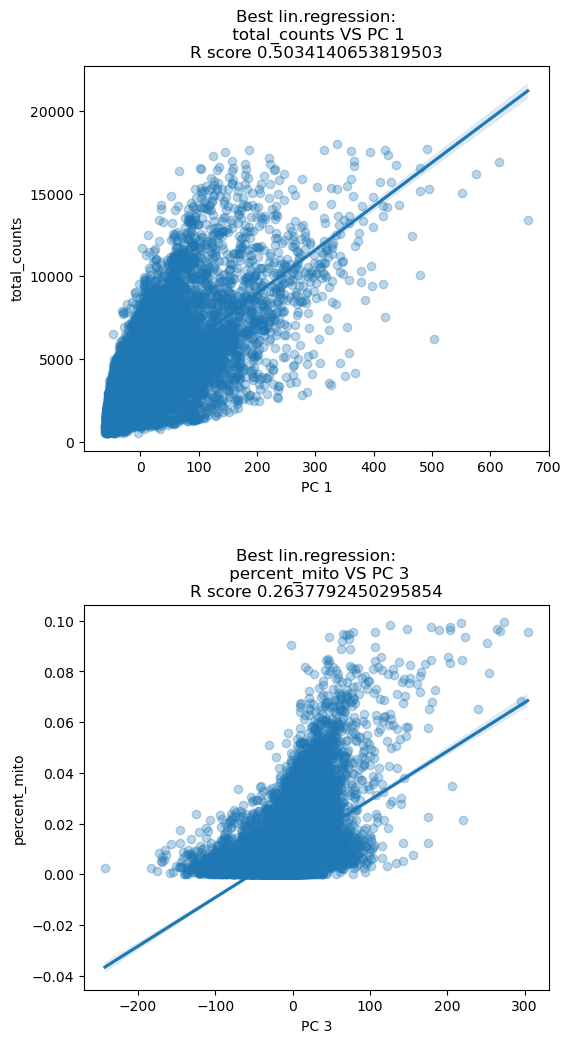

In [10]:
#from /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/tutorial/Scripts/pythonScripts import dependentFeatures

#PCA on unnormalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito']) # plots the PC with the highest R2 to total counts and percent mito, respectively


The third biggest variation in the data at this point is explained by total UMI count. Normalizing with TPM should remove this bias.

In [11]:
adata

AnnData object with n_obs × n_vars = 16250 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced'

In [12]:
rawMatrix = adata.X.todense().T
cells = adata.obs_names
genes = adata.var_names
dataset = np.array(adata.obs["DATASET"])

In [13]:
rawMatrix.shape

(27947, 16250)

In [14]:
%%R -i rawMatrix -i cells -i genes -i dataset -o norm_sct -o umi_corr -o genes_var

library(Seurat)
colnames(rawMatrix) <- cells
rownames(rawMatrix) <- genes
meta <- data.frame(DATASET = dataset)  # add batch as metadata
print(dim(rawMatrix))
seurat_df <- CreateSeuratObject(rawMatrix)
seurat_df <- AddMetaData(seurat_df, meta$DATASET, col.name = "DATASET")
# scTransform
seurat_df <- SCTransform(seurat_df, verbose = TRUE, variable.features.n = length(genes), vars.to.regress = c("DATASET"), return.only.var.genes=FALSE) # normalize data with Negative binomial regression
# Get matrix of residuals
norm_sct <- GetAssayData(seurat_df,assay="SCT",slot="scale.data") # assign normalized and scaled data (not 0 mean scaling)
umi_corr <- GetAssayData(seurat_df,assay="SCT",slot="counts")
genes_var <- rownames(seurat_df$SCT)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject



[1] 27947 16250


R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 27947 by 16250

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 21 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 27947 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 27947 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 3.571754 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out DATASET

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                        

In [15]:
norm_sct.shape

(27947, 16250)

In [16]:
# remove objects from R workspace that I will no longer need
# %%R
# rm(list = ls())

In [17]:
adata.var_names = ["-".join(x.split("_")) for x in adata.var_names] # change _ in gene names to - so it works in R code
adata = adata[:,np.array(genes_var)].copy() # only use genes ...
# creating SCT layers in anndata object
adata.layers["norm_sct"] = norm_sct.T
adata.layers["umi_corr"] = umi_corr.T

In [18]:
adata.X = adata.layers['norm_sct'].copy() # normalized and scaled matrix as default

In [19]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:42)


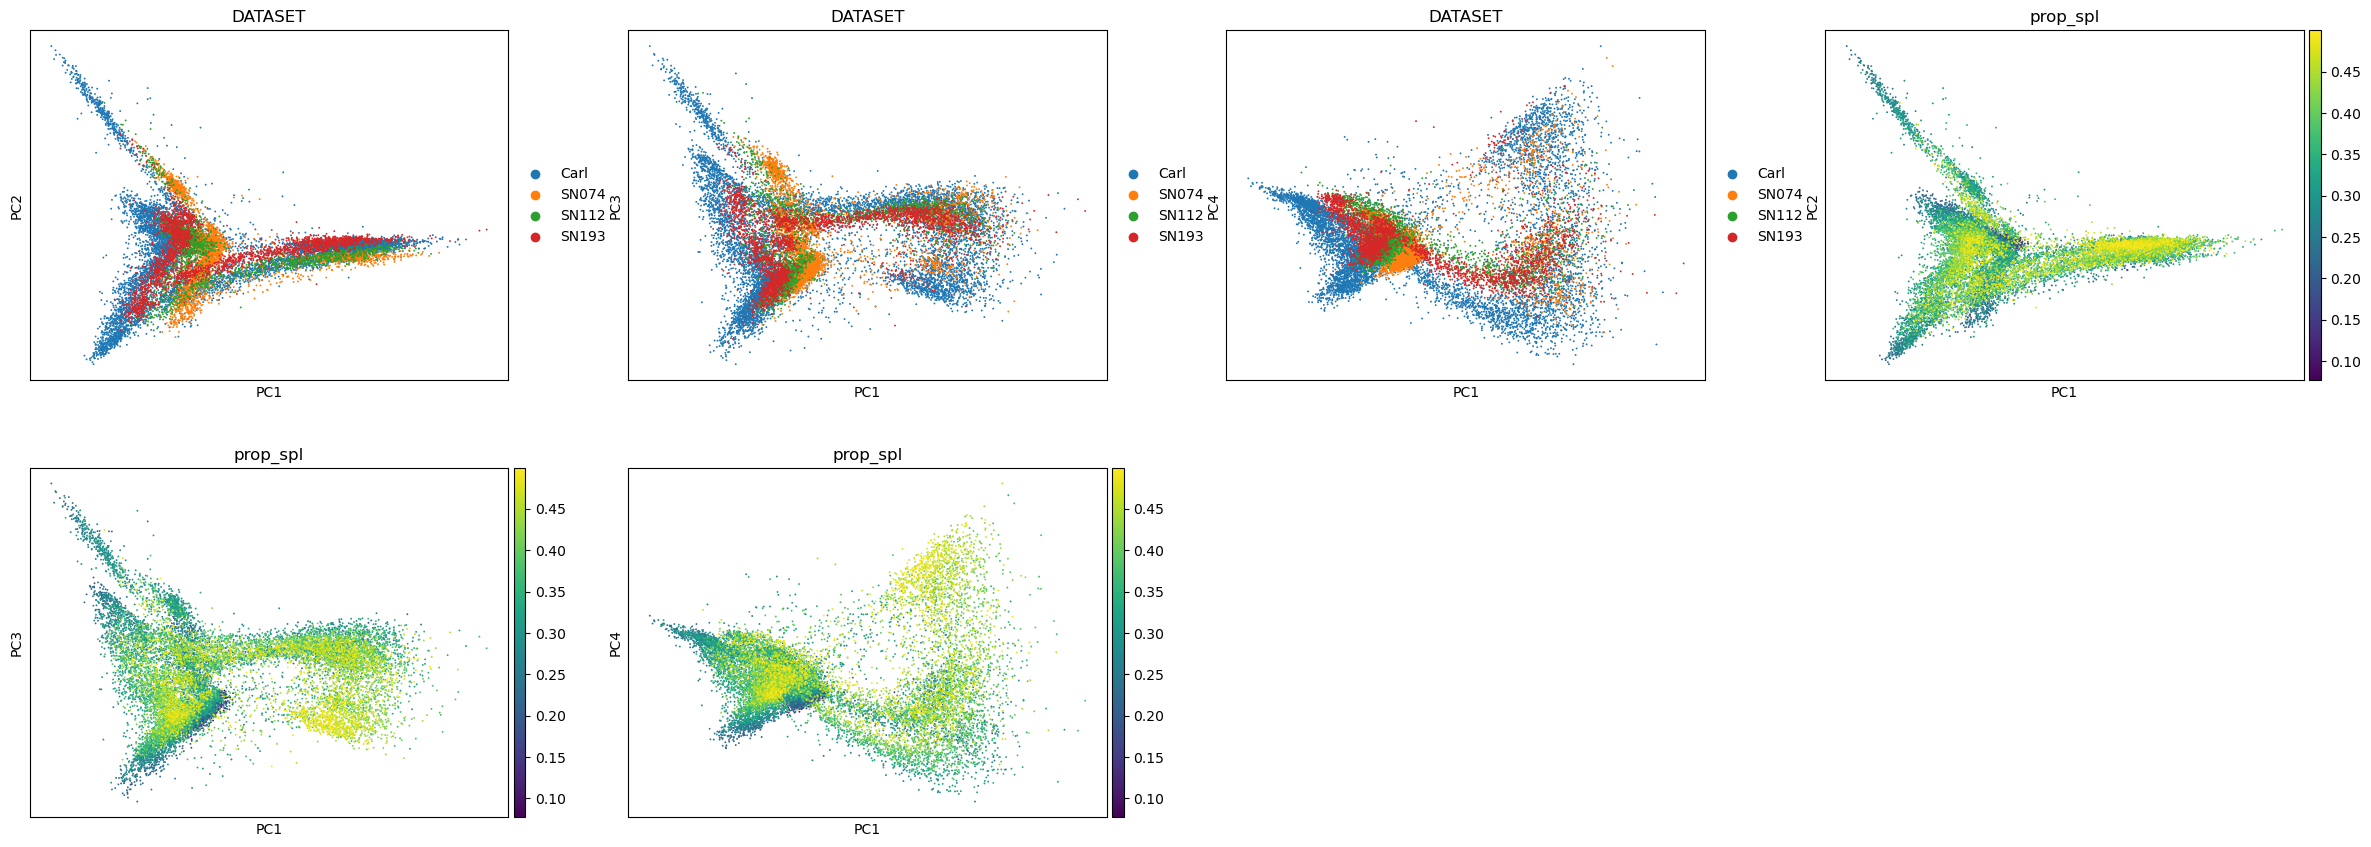

In [20]:
sc.pl.pca(adata, color=['DATASET','prop_spl'], components=['1,2','1,3','1,4'])

In [21]:
# most variable genes, True or False
sc.pp.highly_variable_genes(adata, n_top_genes=10000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:25)


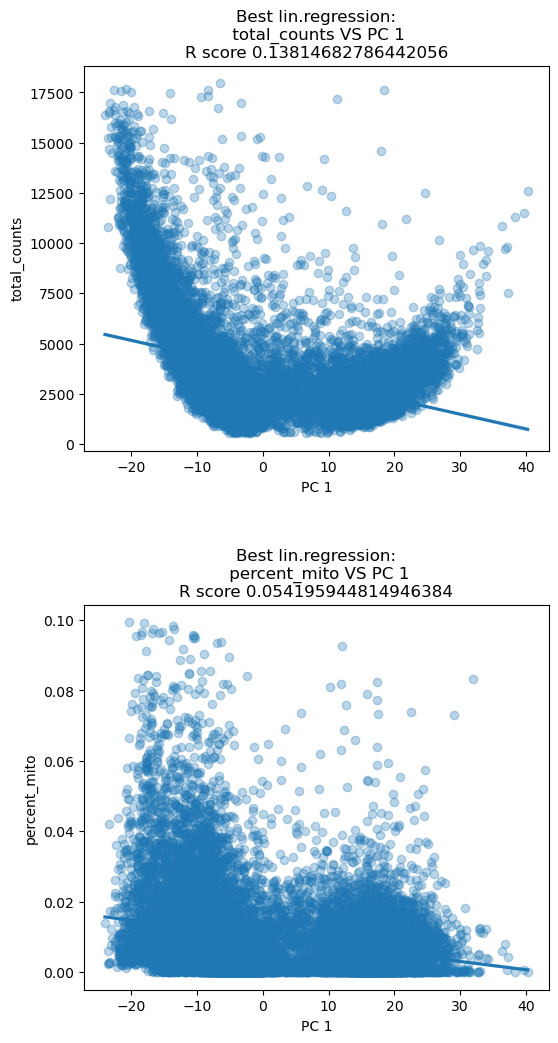

In [22]:
#PCA on normalized data
sc.preprocessing.pca(adata, svd_solver='arpack', random_state=12345)
#Calculating correlations
dependentFeatures(adata=adata, obs_subset=['total_counts','percent_mito'])

Now the correlation isn't strong.

Luckily the samples overlap, so they can be analyzed combined

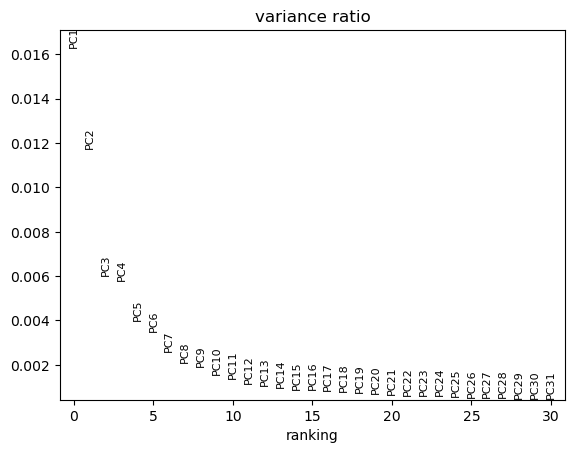

In [23]:
sc.plotting.pca_variance_ratio(adata) # small variance means it probably models noice in the data

Keep the PCs with the most variance, e.g. up to PC10

In [87]:
#sc.pp.neighbors(adata, n_pcs=15, random_state=12345) # use only for data with one single sample
bbknn.bbknn(adata, batch_key='DATASET', n_pcs=30, neighbors_within_batch=3) # increase number

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [88]:
sc.tools.umap(adata, random_state=54321)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


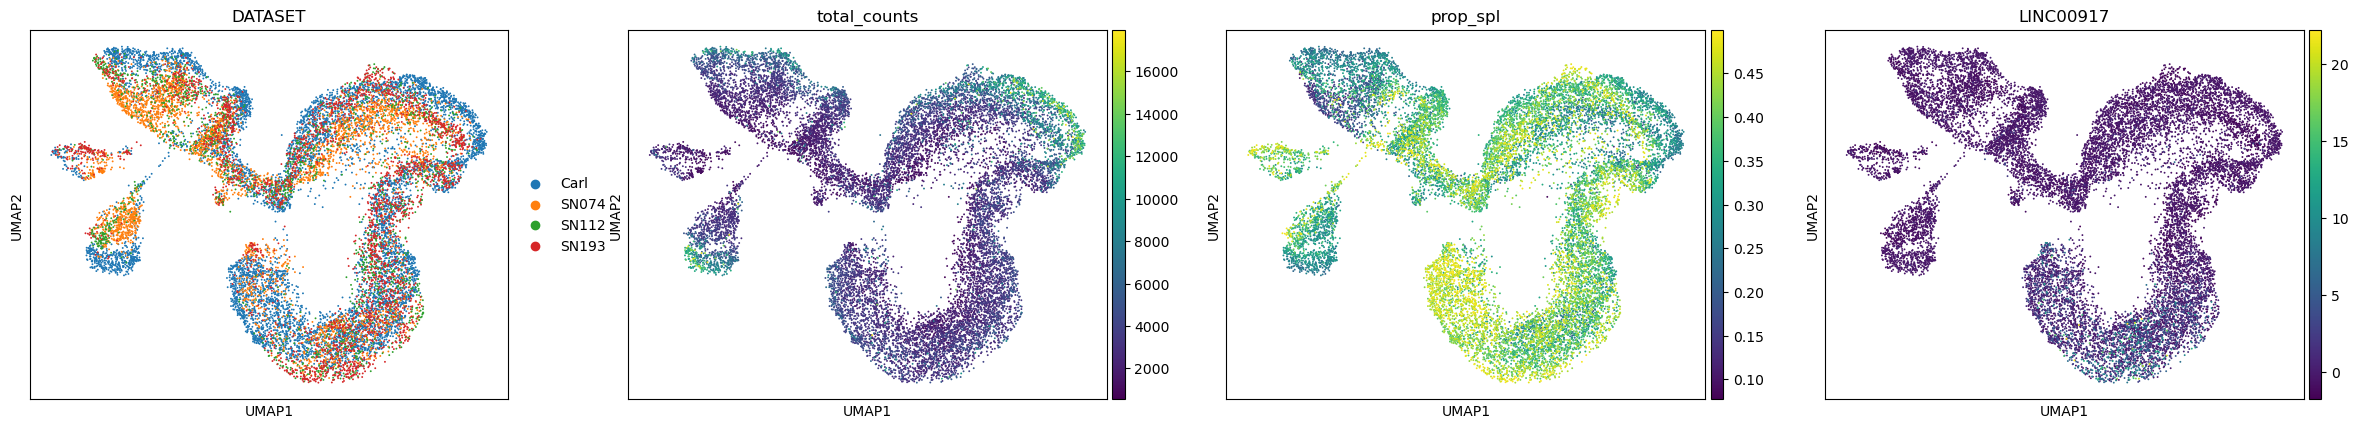

In [89]:
sc.plotting.umap(adata, color=['DATASET','total_counts','prop_spl','LINC00917'])

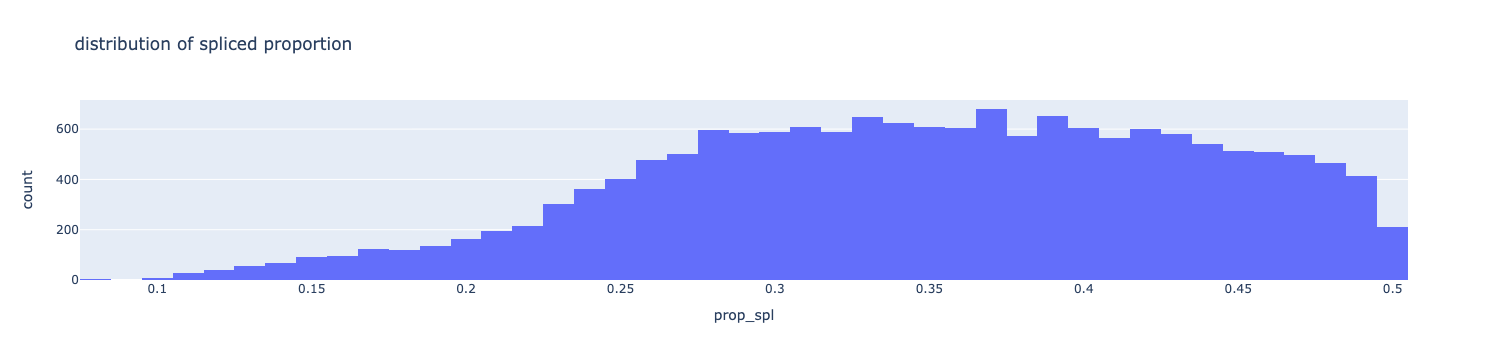

In [90]:
fig = px.histogram(adata.obs['prop_spl'], x='prop_spl', nbins=50,
                  title='distribution of spliced proportion')
fig.show()

In [97]:
adata

AnnData object with n_obs × n_vars = 16250 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [33]:
markers = dict() #make an empty dictionary
# Markers from the group google doc added
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1','PIWIL4','UTF1','SLC22A2','FGFR3']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8','ANP32B','SDF2L1','DMRT1','NANOS3'] # add markers for both?
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101','SPAG6','FTHL17','ART3','KCTD19','ASRGL1','LDHAL6B','LYAR','ZPBP2','ADAM2','CLGN','DDX25'] # general 'MYBL1','SYCP3','HORMAD1','SYNGR4', missing a few pachytene markers
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN','UBE2T']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1','DNAJB13','EFHB','LYZL6','PSD3','SLC16A7','TBC1D21','TMEM144'] # missing a few markers
markers['Elong.Spt'] = ['PRM1','PRM2','AGPAT2','AKAP1','BAG1','CST8','DNAJB7','DNAJB8','FNDC8','LELP1','RANGAP1','SPATA3','TSSK6','TXNDC2','TNP1','TP53TG5']
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL','VIM','ACSL4','WT1','GAS6','BCAR1','DMRT1']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['ACTA2','CFD','IGF1','IGFBP5','CYP19A1','CYP17A1','INSL3']
markers['Endothelial'] = ['CD34']

In [36]:
# higher marker scores when only a few is considered and therefore more visible clusters
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']

In [98]:
# markers in article and course mixed
markers = dict() #make an empty dictionary
#markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8'] 
### SPERMATOCYTOGENESIS
markers['Undif. SG'] = ['ID4','HMGA1']
markers['Dif. SG'] = ['MKI67','DMRT1','STRA8'] 
markers['SC.I'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SC.II'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Early round SD'] = ['LRRIQ1'] #Round spermatids, Distinct #better than tutorial
markers['Late round SD'] = ['ACRV1','SPACA1'] #Round spermatids, Distinct #better than tutorial
markers['Elong SD'] = ['SPATA3','NRBP1','PRM1','GABBR2'] #Elongated spermatids #better than tutorial
### SOMATIC CELLS
markers['Sertoli'] = ['CLU'] # very distinct #better than tutorial
markers['Macroph'] = ['APOE','CD74']
markers['Leydig'] = ['STAR','CYP11A1']
markers['Endothelial'] = ['CD34'] #'TM4SF1' not expressed

In [99]:
markers_scores, adata = marker_score(markers, adata)

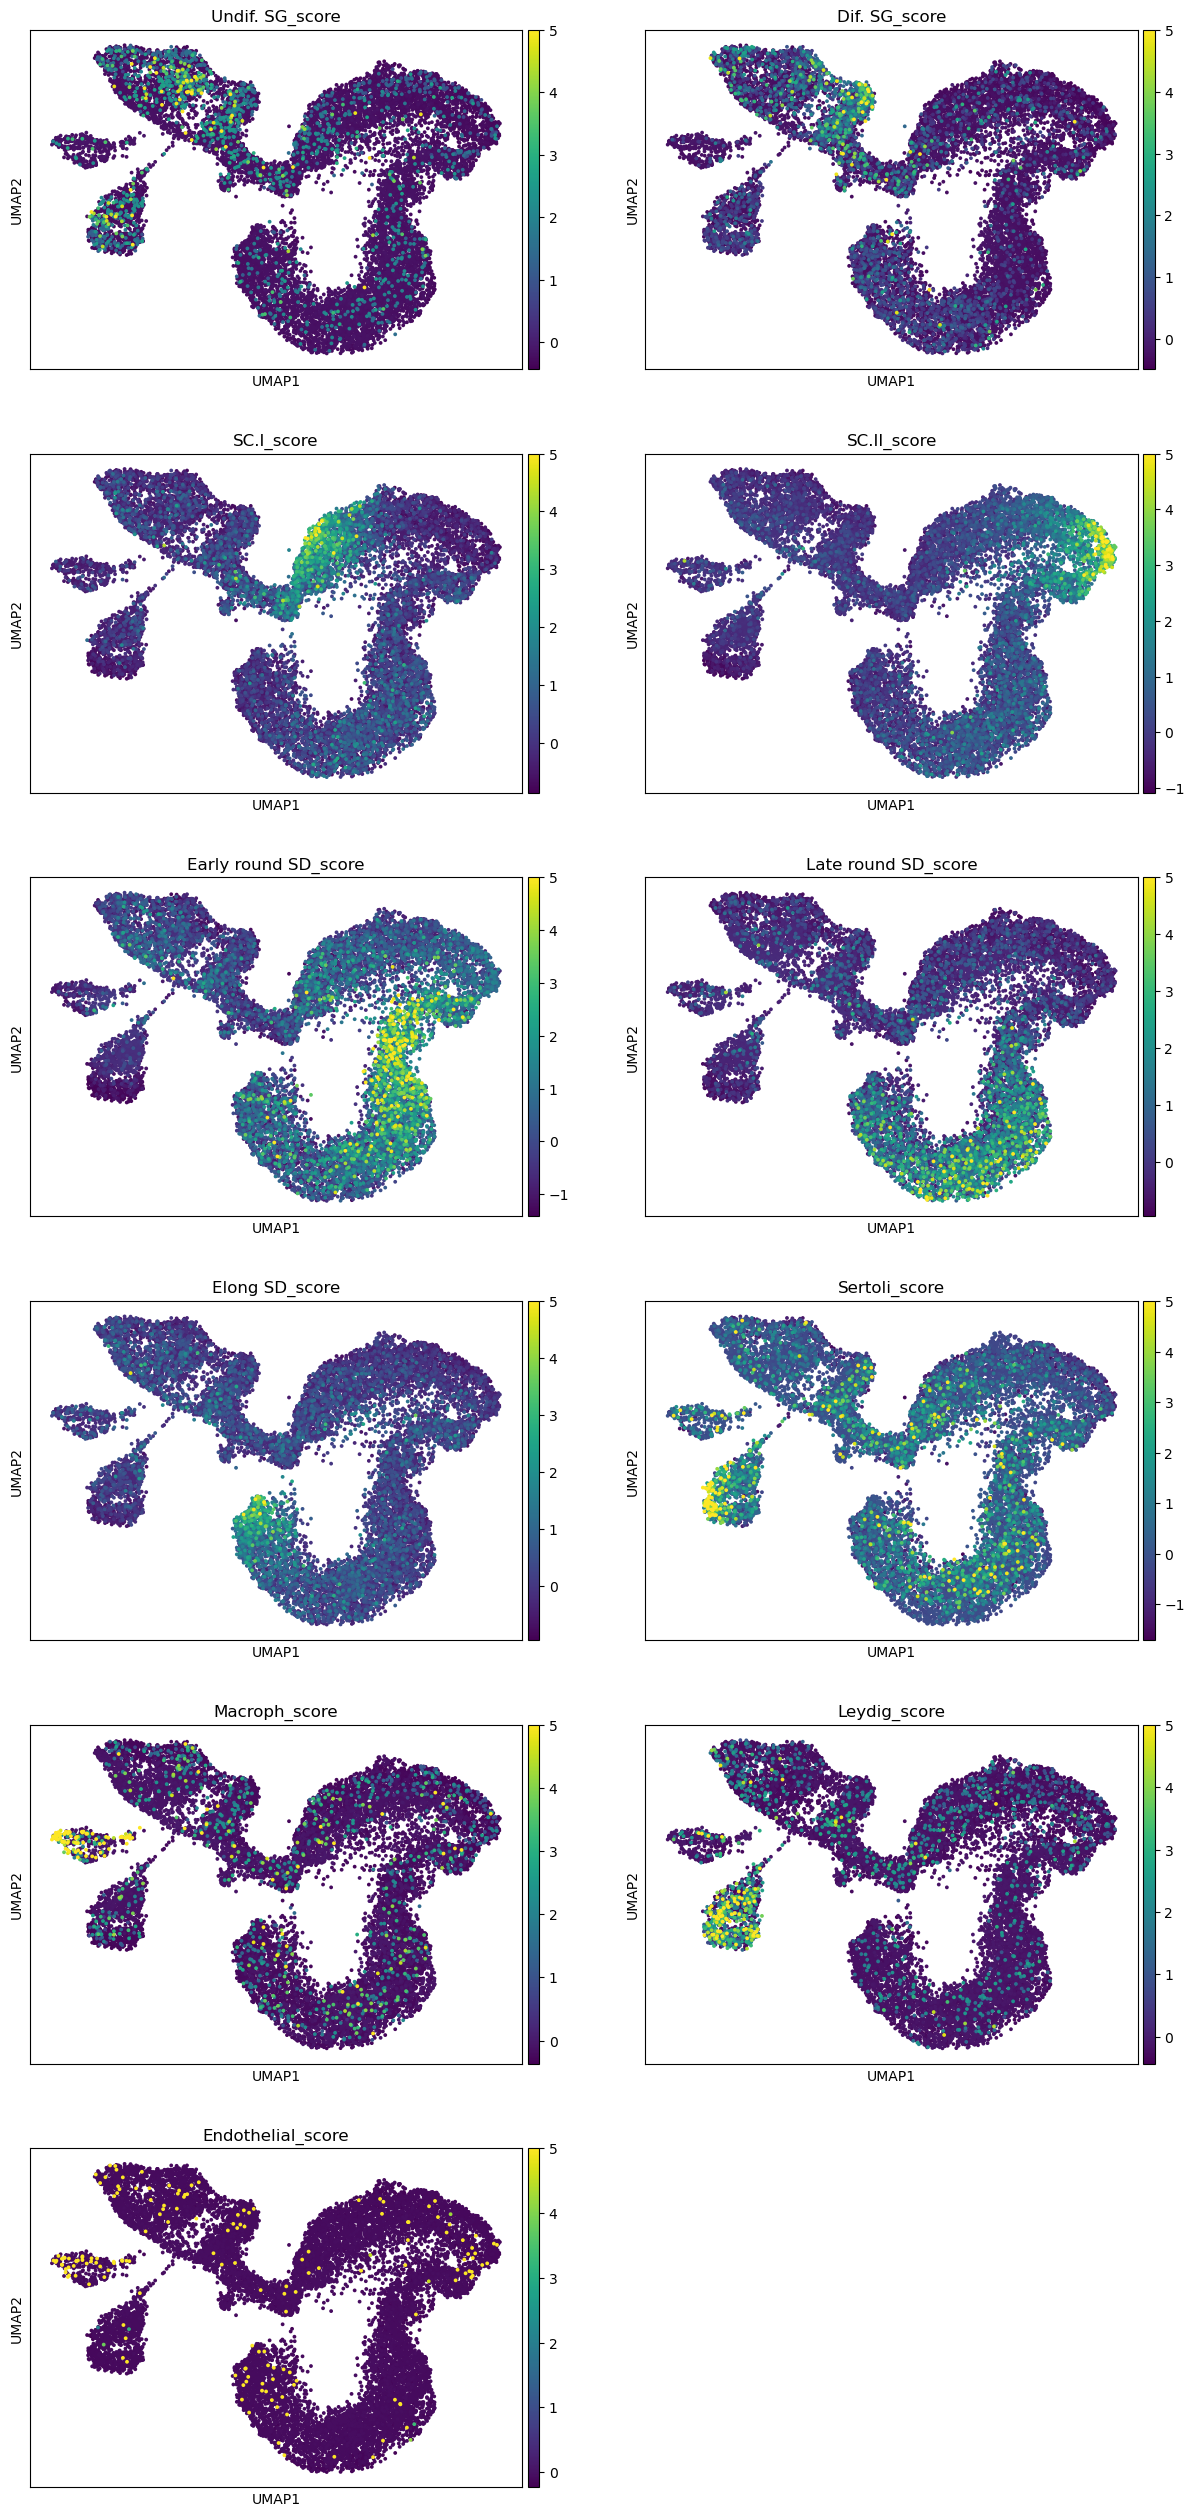

In [100]:
sc.plotting.umap(adata, color=markers_scores, components=['1,2'], ncols=2, vmax=5, s=30)

In [101]:
#leiden clustering at various resolutions
sc.tools.leiden(adata, resolution=0.4, random_state=12345, key_added='leiden_R.4')
sc.tools.leiden(adata, resolution=0.3, random_state=12345, key_added='leiden_R.3')
sc.tools.leiden(adata, resolution=0.2, random_state=12345, key_added='leiden_R.2')
sc.tools.leiden(adata, resolution=0.1, random_state=12345, key_added='leiden_R.1')

running Leiden clustering
    finished: found 10 clusters and added
    'leiden_R.4', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_R.3', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_R.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_R.1', the cluster labels (adata.obs, categorical) (0:00:00)


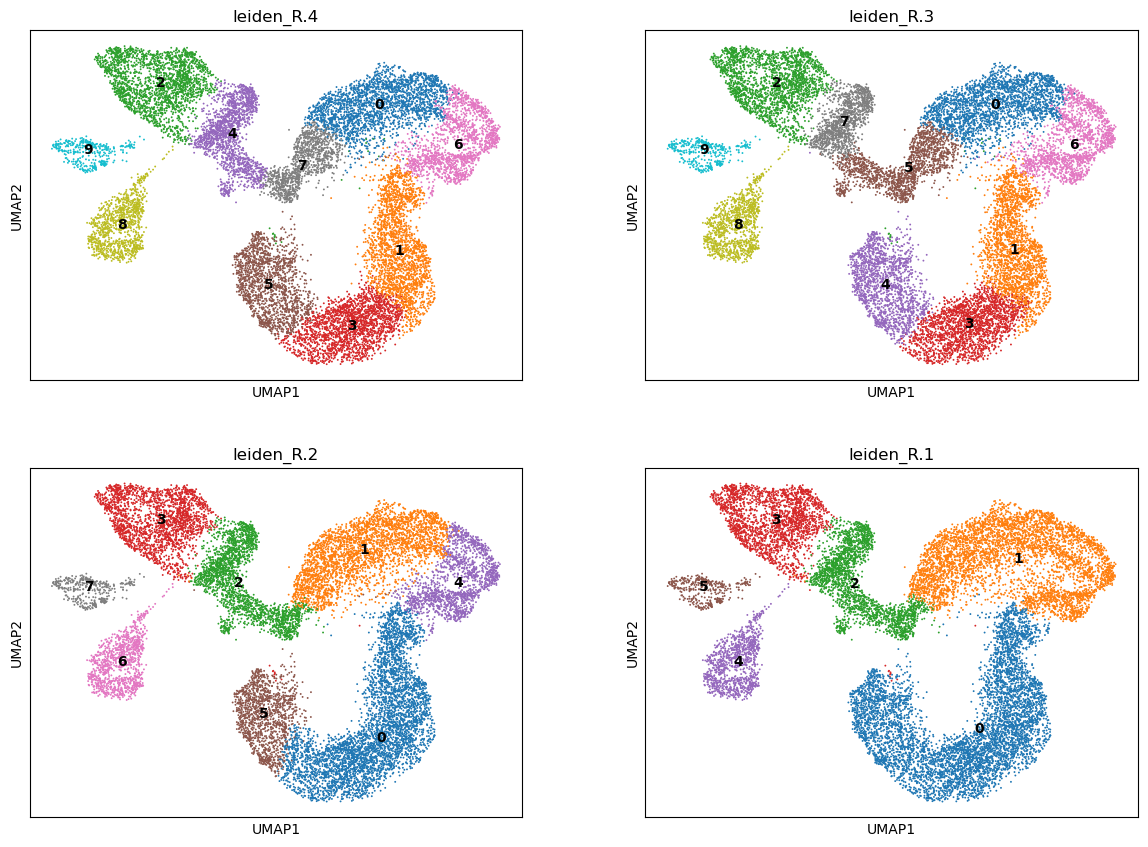

In [102]:
sc.plotting.umap(adata, color=['leiden_R.4','leiden_R.3','leiden_R.2','leiden_R.1'], legend_loc='on data', ncols=2)

In [103]:
adata

AnnData object with n_obs × n_vars = 16250 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

Comparing the Leiden clusters to the clusters represented by cell markers resolution 0,4 match the best

In [104]:
sc.tl.rank_genes_groups(adata, groupby='leiden_R.4', n_genes=50, key_added='DE_leiden') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:26)


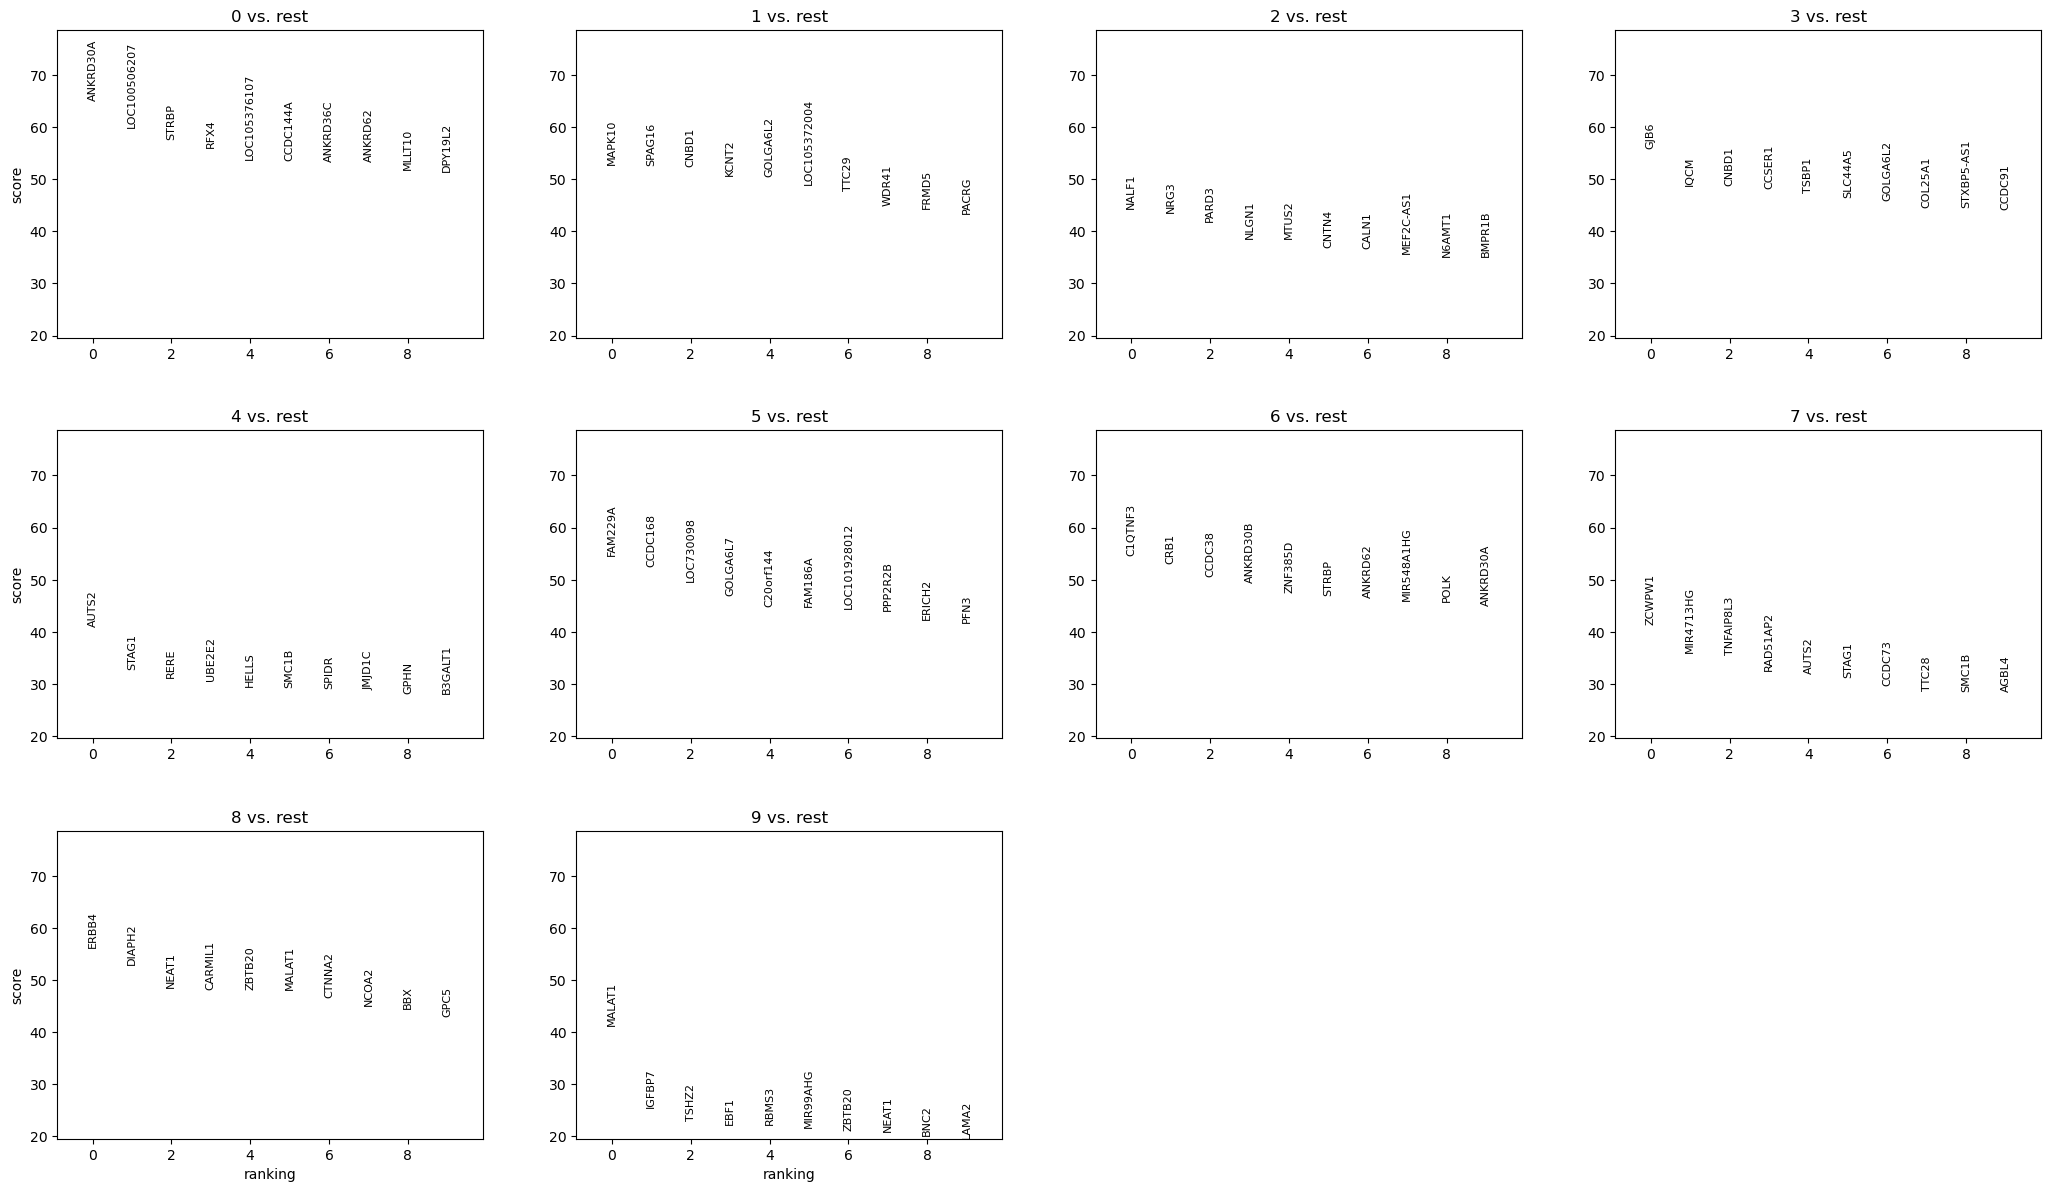

In [107]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='leiden_R.4', key='DE_leiden') # sharey=False to change y axis to individual score

In [108]:
adata

AnnData object with n_obs × n_vars = 16250 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'DE_leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

Organize result in a table. Each column has the cluster numbers with _N, _P, _L representing respectively the gene Names, their P-values and the Log-fold change of each gene expression compared to the other clusters.

In [109]:
result = adata.uns['DE_leiden']
groups = result['names'].dtype.names
X = pd.DataFrame(
    {group + '_' + key[:1].upper(): result[key][group]
    for group in groups for key in ['names', 'pvals_adj']})
X.head() #print only first five lines

0_N  0_P       1_N  1_P    2_N            2_P     3_N  3_P  \
0      ANKRD30A  0.0    MAPK10  0.0  NALF1  7.592004e-305    GJB6  0.0   
1  LOC100506207  0.0    SPAG16  0.0   NRG3  1.080530e-295    IQCM  0.0   
2         STRBP  0.0     CNBD1  0.0  PARD3  5.748694e-281   CNBD1  0.0   
3          RFX4  0.0     KCNT2  0.0  NLGN1  1.334202e-251  CCSER1  0.0   
4  LOC105376107  0.0  GOLGA6L2  0.0  MTUS2  5.192194e-248   TSBP1  0.0   

      4_N            4_P        5_N            5_P       6_N            6_P  \
0   AUTS2  1.721108e-262    FAM229A   0.000000e+00   C1QTNF3   0.000000e+00   
1   STAG1  1.084533e-183    CCDC168   0.000000e+00      CRB1   0.000000e+00   
2    RERE  7.981070e-170  LOC730098   0.000000e+00    CCDC38   0.000000e+00   
3  UBE2E2  2.006997e-164   GOLGA6L7  1.933581e-308  ANKRD30B   0.000000e+00   
4   HELLS  7.624706e-153  C20orf144  2.913707e-289   ZNF385D  4.107925e-306   

         7_N            7_P      8_N            8_P     9_N            9_P  
0     ZCWPW1  1.306501e-228    ERBB4  1.032103e-320  MALAT1  7.430609e-141  
1  MIR4713HG  5.704940e-189   DIAPH2  4.658770e-302  IGFBP7   2.359126e-82  
2  TNFAIP8L3  4.279090e-186    NEAT1  1.072049e-273   TSHZ2   3.415304e-72  
3   RAD51AP2  7.851639e-164  CARMIL1  1.870661e-269    EBF1   1.439191e-69  
4      AUTS2  1.271088e-161   ZBTB20  1.587159e-272   RBMS3   1.482057e-69

In [110]:
pd.DataFrame(adata.uns['DE_leiden']['names']).head() # top 5 ranked genes for each cluster

0         1      2       3       4          5         6  \
0      ANKRD30A    MAPK10  NALF1    GJB6   AUTS2    FAM229A   C1QTNF3   
1  LOC100506207    SPAG16   NRG3    IQCM   STAG1    CCDC168      CRB1   
2         STRBP     CNBD1  PARD3   CNBD1    RERE  LOC730098    CCDC38   
3          RFX4     KCNT2  NLGN1  CCSER1  UBE2E2   GOLGA6L7  ANKRD30B   
4  LOC105376107  GOLGA6L2  MTUS2   TSBP1   HELLS  C20orf144   ZNF385D   

           7        8       9  
0     ZCWPW1    ERBB4  MALAT1  
1  MIR4713HG   DIAPH2  IGFBP7  
2  TNFAIP8L3    NEAT1   TSHZ2  
3   RAD51AP2  CARMIL1    EBF1  
4      AUTS2   ZBTB20   RBMS3

In [111]:
cd /home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results

/faststorage/project/testis_singlecell/Workspaces/adahl/birc-project-akd/results


In [112]:
!mkdir -p cluster_results/CHIMP

In [113]:
X.to_csv('cluster_results/CHIMP/expr_annotation.csv', sep=',', index=None)

In [114]:
# cell type names for the chosen clusters

#new_names = {
#    '0':'SpermatogoniaA.1',
#    '1':'SpermatogoniaA.2',
#    '2':'Myoid',
#    '3':'Endothelial',
#    '4':'Leydig',
#    '5':'SpermatogoniaB',
#    '6':'Elong_Spermatids',
#    '7':'SpermatocitesII.1',
#    '8':'SpermatocitesII.2',
#    '9':'Round_Spermatids',
#    '10':'SpermatocitesI',
#    '11':'Macroph',
#    '12':'Pericytes'}


new_names = {
    '0':'SC.I',
    '1':'Early round SD',
    '2':'Undif. SG',
    '3':'Late round SD',
    '4':'Dif. SG',
    '5':'Elong. SD',
    '6':'SC.II',
    '7':'SC.I',
    '8':'Sertoli',
    '9':'Macrophage'
}


We merge the clusters with same names. This cannot be done with a categorical object, where categories cannot have the same name. We convert the cluster names into a simple array to do this, and then reconvert it to a categorical object.

In [115]:
adata.obs['spermatogenesis_types'] = [new_names[x] for x in adata.obs['leiden_R.4'].tolist()]

In [116]:
palette_dict = {"Undif. SG":'lightblue',"Dif. SG":'blue',"SC.I":'lightgreen','SC.II':'green','Early round SD':'yellow','Late round SD':'orange','Elong. SD':'red','Sertoli':'pink','Macrophage':'brown'}

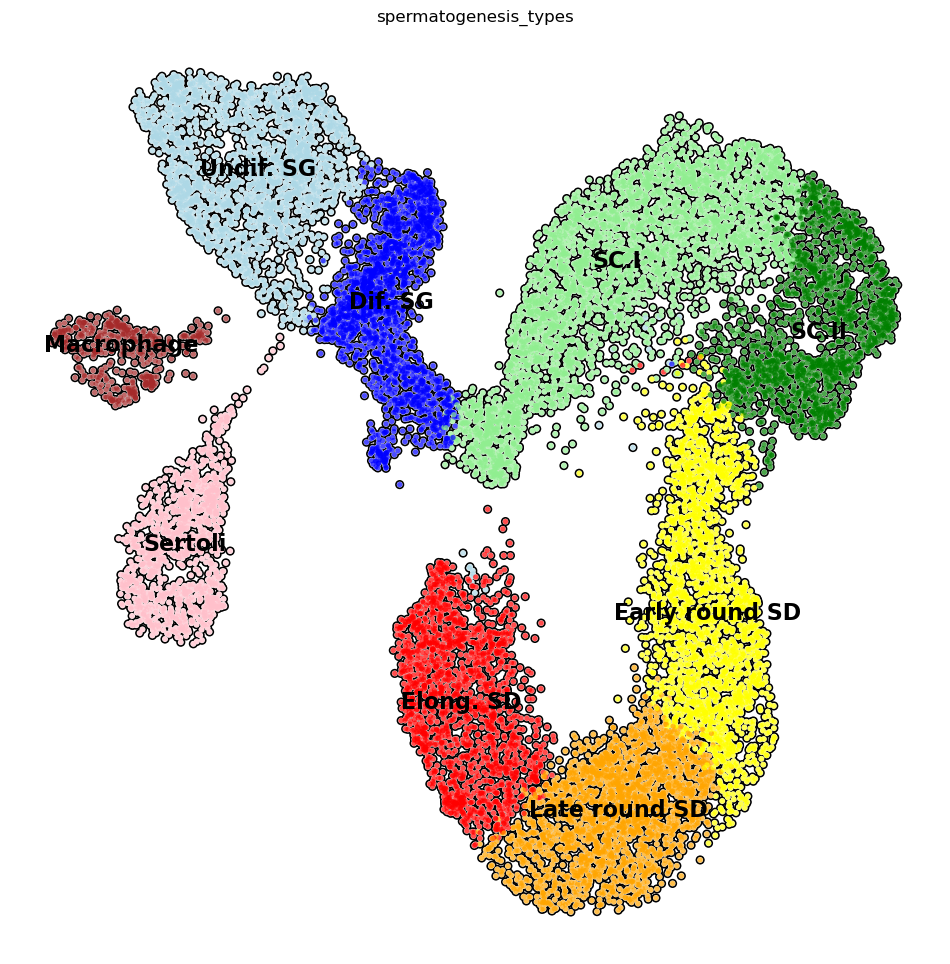

In [117]:
plt.rcParams['figure.figsize'] = (12,12)
sc.pl.umap( adata, color=['spermatogenesis_types'], 
           palette=palette_dict,
           legend_loc='on data', 
           legend_fontsize=16,
           frameon=False,
           size=60,
           add_outline=True,
           ncols=1  
           )

In [8]:
saved_adata = '/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/CHIMP/cluster_adata.h5ad'
adata = sc.read(saved_adata)

In [118]:
adata

AnnData object with n_obs × n_vars = 16250 × 27947
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1', 'n_genes', 'doublet_scores', 'predicted_doublets', 'Undif. SG_score', 'Dif. SG_score', 'SC.I_score', 'SC.II_score', 'Early round SD_score', 'Late round SD_score', 'Elong SD_score', 'Sertoli_score', 'Macroph_score', 'Leydig_score', 'Endothelial_score', 'leiden_R.4', 'leiden_R.3', 'leiden_R.2', 'leiden_R.1', 'spermatogenesis_types'
    var: 'gene_ids', 'feature_types', 'chromosome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'DATASET_colors', 'hvg', 'neighbors', 'umap', 'leiden', 'leiden_R.4_colors', 'leiden_R.3_colors', 'leiden_R.2_colors', 'leiden_R.1_colors', 'DE_leiden', 'spermatogenesis_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'spliced', 'unspliced', 'norm_sct', 'umi_corr'
    obsp: 'distances', 'connectivities'

In [119]:
sc.tl.rank_genes_groups(adata, groupby='spermatogenesis_types', n_genes=50, key_added='DE_leiden_celltype') # diff.expressed genes in each cluster (t-test)

ranking genes
    finished: added to `.uns['DE_leiden_celltype']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:25)


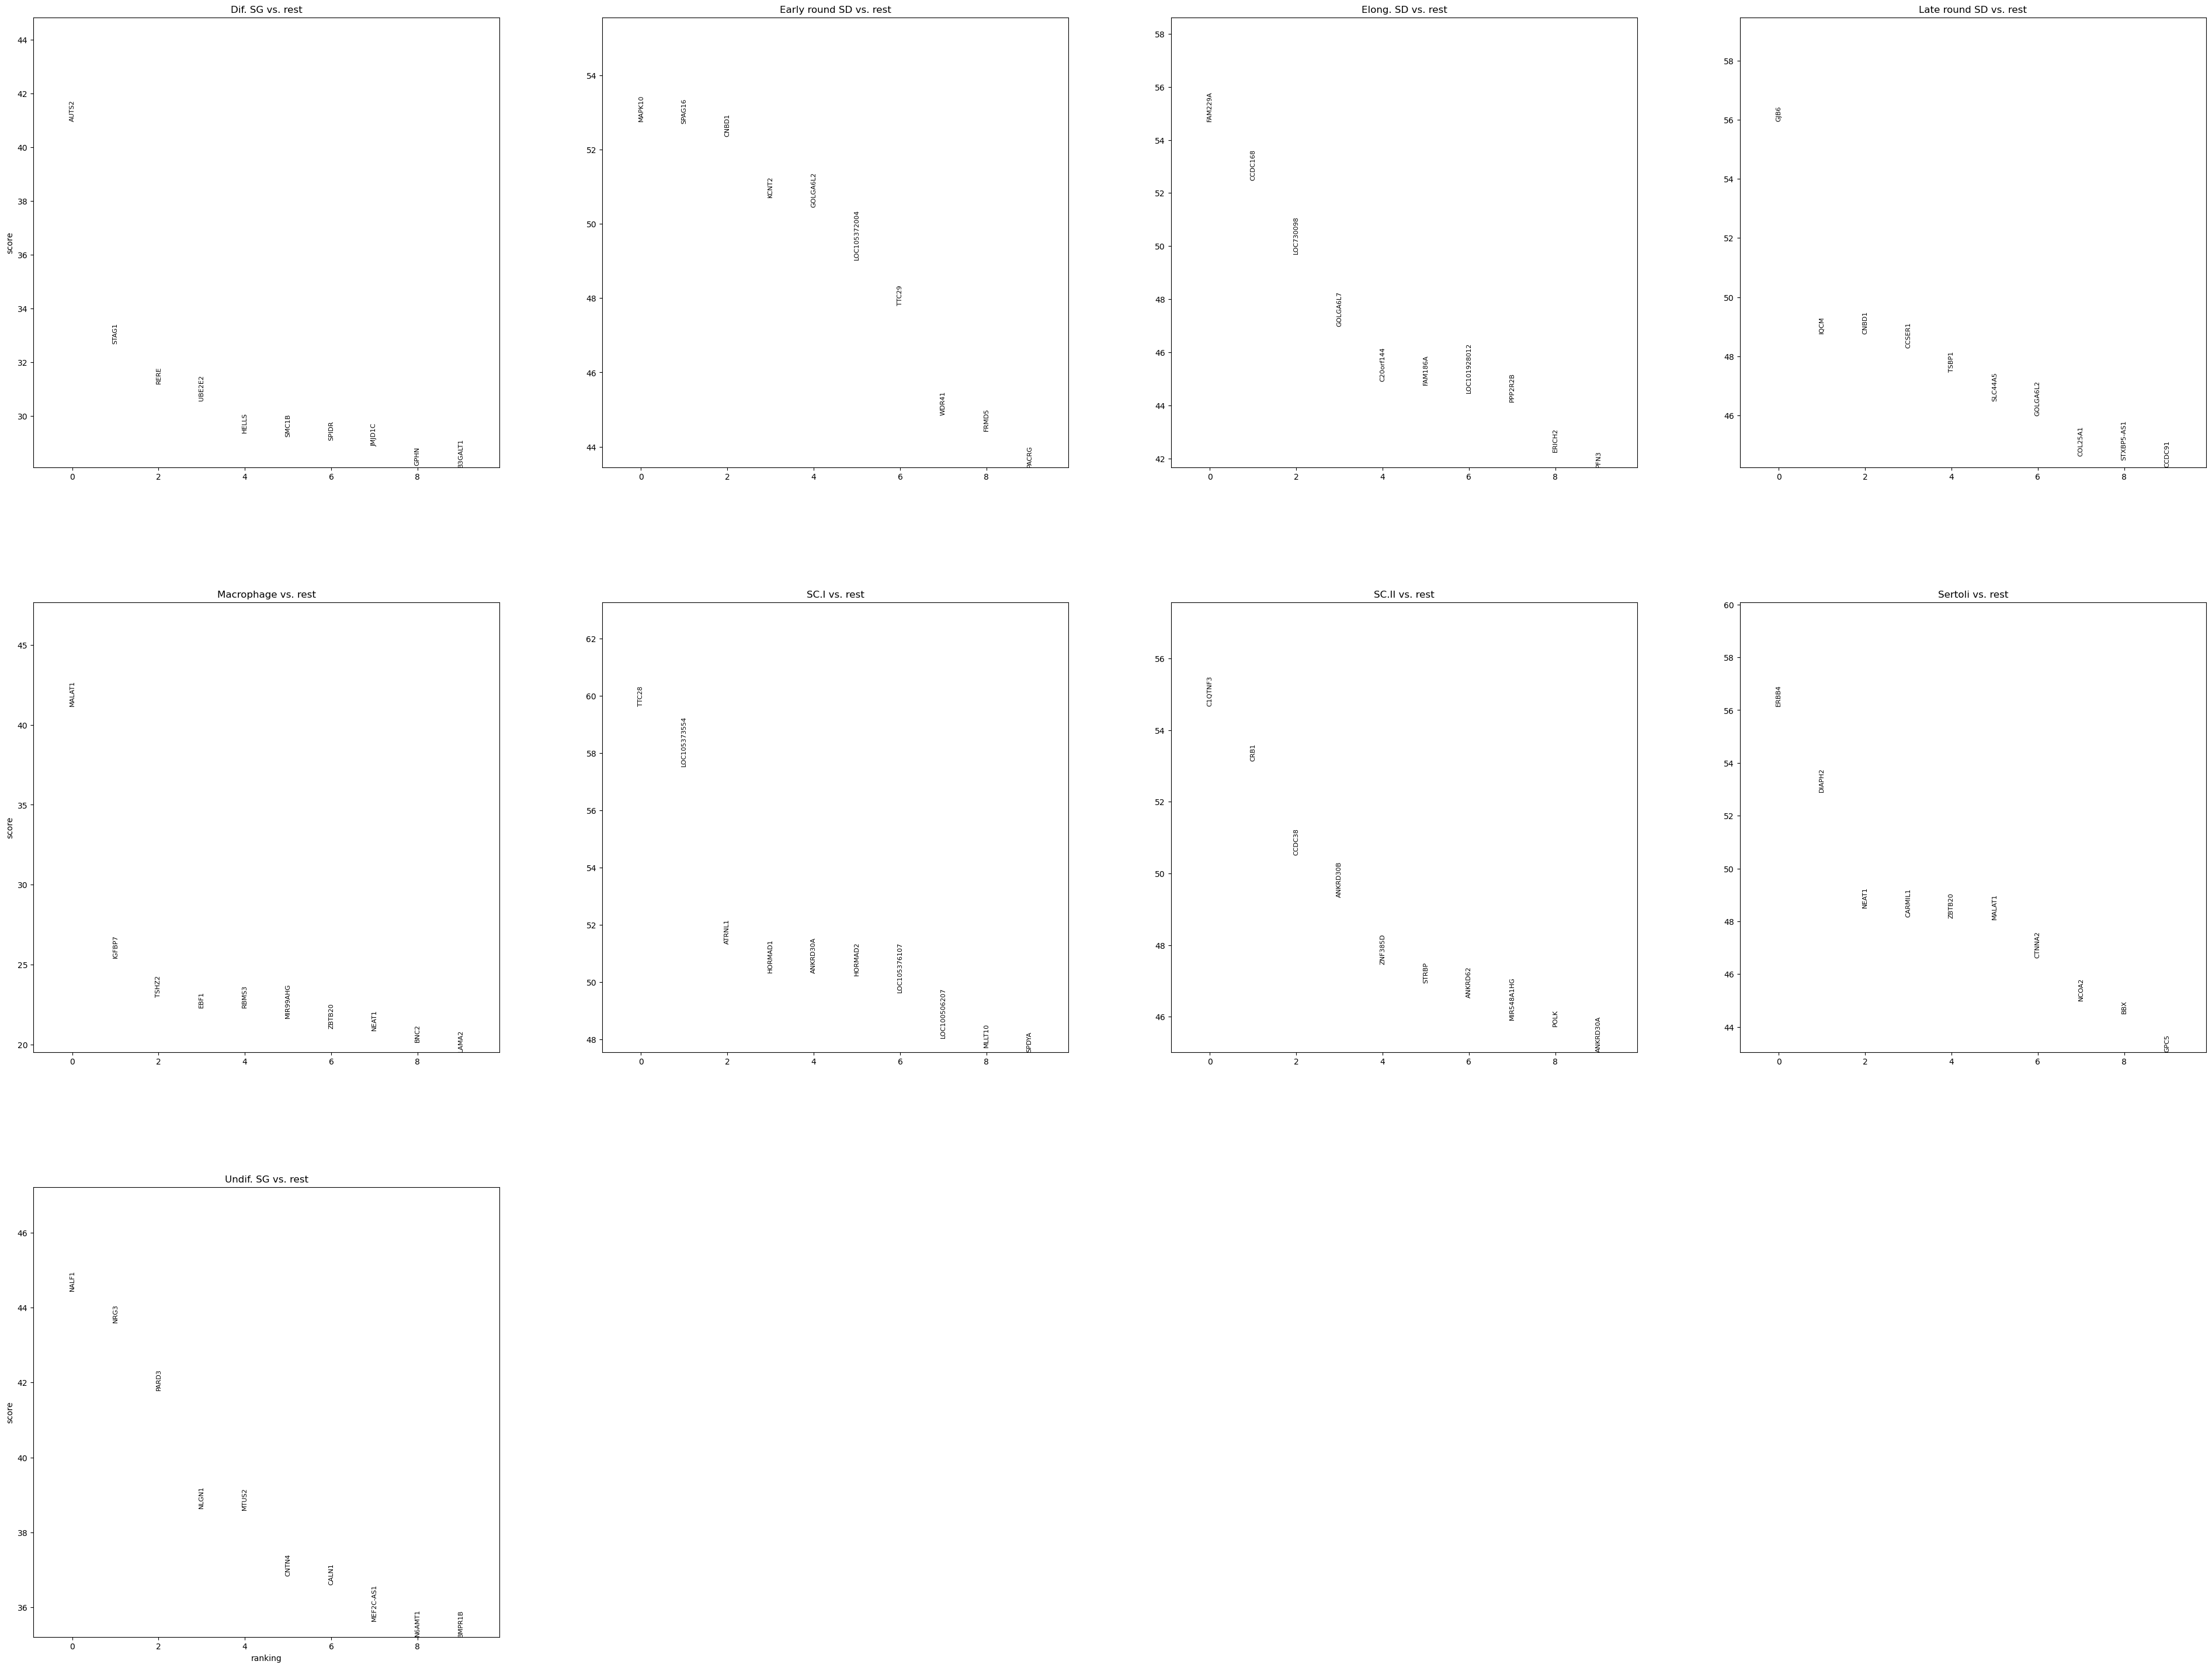

In [120]:
sc.pl.rank_genes_groups(adata, n_genes=10, groupby='spermatogenesis_types', key='DE_leiden_celltype', sharey=False) # sharey=False to change y axis to individual score

In [121]:
result2 = adata.uns['DE_leiden_celltype']
groups2 = result2['names'].dtype.names
X2 = pd.DataFrame(
    {group + '_' + key[:1].upper(): result2[key][group]
    for group in groups2 for key in ['names', 'pvals_adj']})
X2.head() #print only first five lines

Dif. SG_N      Dif. SG_P Early round SD_N  Early round SD_P Elong. SD_N  \
0     AUTS2  1.721108e-262           MAPK10               0.0     FAM229A   
1     STAG1  1.084533e-183           SPAG16               0.0     CCDC168   
2      RERE  7.981070e-170            CNBD1               0.0   LOC730098   
3    UBE2E2  2.006997e-164            KCNT2               0.0    GOLGA6L7   
4     HELLS  7.624706e-153         GOLGA6L2               0.0   C20orf144   

     Elong. SD_P Late round SD_N  Late round SD_P Macrophage_N   Macrophage_P  \
0   0.000000e+00            GJB6              0.0       MALAT1  7.430609e-141   
1   0.000000e+00            IQCM              0.0       IGFBP7   2.359126e-82   
2   0.000000e+00           CNBD1              0.0        TSHZ2   3.415304e-72   
3  1.933581e-308          CCSER1              0.0         EBF1   1.439191e-69   
4  2.913707e-289           TSBP1              0.0        RBMS3   1.482057e-69   

         SC.I_N  SC.I_P   SC.II_N        SC.II_P Sertoli_N      Sertoli_P  \
0         TTC28     0.0   C1QTNF3   0.000000e+00     ERBB4  1.032103e-320   
1  LOC105373554     0.0      CRB1   0.000000e+00    DIAPH2  4.658770e-302   
2        ATRNL1     0.0    CCDC38   0.000000e+00     NEAT1  1.072049e-273   
3       HORMAD1     0.0  ANKRD30B   0.000000e+00   CARMIL1  1.870661e-269   
4      ANKRD30A     0.0   ZNF385D  4.107925e-306    ZBTB20  1.587159e-272   

  Undif. SG_N    Undif. SG_P  
0       NALF1  7.592004e-305  
1        NRG3  1.080530e-295  
2       PARD3  5.748694e-281  
3       NLGN1  1.334202e-251  
4       MTUS2  5.192194e-248

In [122]:
X2.to_csv('cluster_results/CHIMP/expr_annotation_celltype.csv', sep=',', index=None)

In [123]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/results/cluster_results/CHIMP'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out = f'{path_out}/cluster_adata.h5ad'

In [124]:
adata.write(adata_out)